In [88]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import sklearn.preprocessing as pp
from skfeature.function.similarity_based import fisher_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

### Linear logistic regression classifier
clf = LogisticRegressionCV(random_state=0, solver='lbfgs', max_iter=50000, multi_class='multinomial', cv=5)
mlp = MLPClassifier(solver='lbfgs', activation='tanh', alpha=1e-5, max_iter=10000, random_state=1)

(30, 400)
(30, 400)


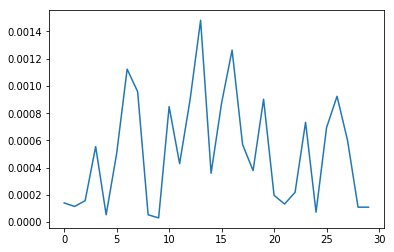

In [89]:
### Load data
mat_content = sio.loadmat("classification/cancerWTrain.mat")
sorted(mat_content.keys())
cancerTestX = mat_content["cancerTestX"]
cancerTrainX = mat_content["cancerTrainX"]
cancerTrainY = mat_content["cancerTrainY"]
print(np.shape(cancerTrainX))

cancer_encoded = np.copy(cancerTrainX)
np.r_[cancer_encoded, cancerTrainY]
print(np.shape(cancer_encoded))

### Standardize data
cancerTrainX = pp.Normalizer().fit(cancerTrainX).transform(cancerTrainX)
cancerTestX = pp.Normalizer().fit(cancerTestX).transform(cancerTestX)
 
## Plot variance of features
feature_variance = np.var(cancerTrainX.T, 0)
plt.plot(feature_variance)



[27  7 22 20  2  0 23  6  3 26  5 25 10 12 13 21 24  1 28 17  4  8 29 15
 16 19 14 11 18  9]


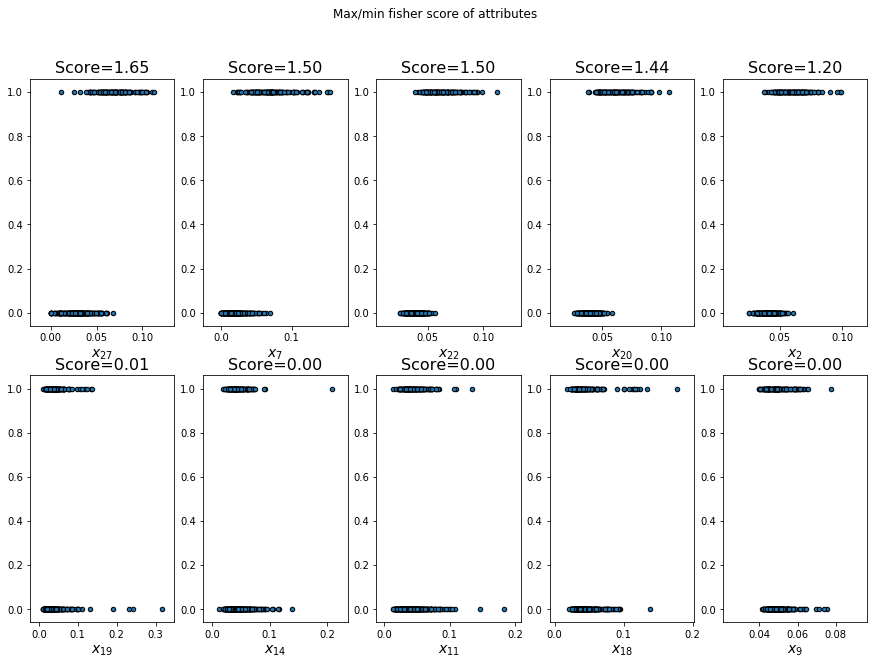

In [90]:
### Feature selection
f_score = fisher_score.fisher_score(cancerTrainX.T, np.ravel(cancerTrainY.T))
attr_rank = fisher_score.feature_ranking(f_score)

print("\n")
print(attr_rank)

# Plot extreme attributes
fig = plt.figure(figsize=(15, 10))
fig.suptitle("Max/min fisher score of attributes")
for i in range(1, 6):
    plt.subplot(2, 5, i)
    plt.scatter(cancerTrainX[attr_rank[i-1]], cancerTrainY, edgecolors='black', s=20)
    plt.xlabel("$x_{}$".format({attr_rank[i-1]}), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("Score={:.2f}".format(f_score[attr_rank[i-1]]), fontsize=16)
for i in range(1, 6):
    plt.subplot(2, 5, 5+i)
    plt.scatter(cancerTrainX[attr_rank[24+i]], cancerTrainY, edgecolors='black', s=20)
    plt.xlabel("$x_{}$".format({attr_rank[24+i]}), fontsize=14)
    if i == 0:
        plt.ylabel("bar", fontsize=14)
    plt.title("Score={:.2f}".format(f_score[attr_rank[24+i]]), fontsize=16)
plt.savefig("pics/extreme_attr", format='png')


In [91]:
### Find best amount of attributes using cross validation
score = []
for i in range(1, 31): 
    score.append(np.mean(cross_val_score(clf, cancerTrainX[attr_rank[0:i]].T, np.ravel(cancerTrainY.T), cv=5)))


In [195]:
## Find best amount of hidden nodes(one hidden layer) with respect to generelization error
mlp_af_score = []   # All features
mlp_bf_score = []   # Best features
for i in range(1, 60):
    mlp.hidden_layer_sizes = (i,)
    mlp_af = mlp
    mlp_af_score.append(cross_val_score(mlp, cancerTrainX.T, np.ravel(cancerTrainY.T), cv=5).mean())
    mlp_bf_score.append(cross_val_score(mlp, cancerTrainX[
        attr_rank[
            0:np.argmax(score)
        ]
    ].T, np.ravel(cancerTrainY.T), cv=5).mean())


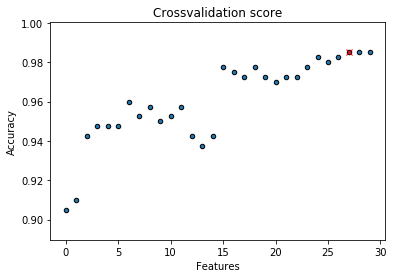

0.985
27




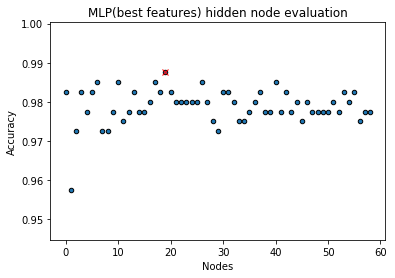

0.9875
19




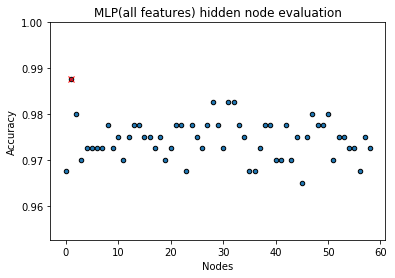

0.9875
1




In [196]:
plt.scatter(np.arange(start=0, stop=len(score)), score, edgecolors='black', s=20)
plt.title("Crossvalidation score")
plt.xlabel("Features")
plt.ylabel("Accuracy")
plt.plot(np.argmax(score), np.max(score), 'rx')
plt.savefig('pics/crossval_score', format='png')
plt.show()
print(np.max(score))
print(np.argmax(score))
print("\n")

plt.scatter(np.arange(start=0, stop=len(mlp_bf_score)), mlp_bf_score, edgecolors='black', s=20)
plt.plot(np.argmax(mlp_bf_score), np.max(mlp_bf_score), 'rx')
plt.title('MLP(best features) hidden node evaluation')
plt.xlabel('Nodes')
plt.ylabel('Accuracy')
plt.savefig("pics/hidden_nodes", format='png')
plt.show()
print(np.max(mlp_bf_score))
print(np.argmax(mlp_bf_score))
print("\n")

plt.scatter(np.arange(start=0, stop=len(mlp_af_score)), mlp_af_score, edgecolors='black', s=20)
plt.plot(np.argmax(mlp_af_score), np.max(mlp_af_score), 'rx')
plt.title('MLP(all features) hidden node evaluation')
plt.xlabel('Nodes')
plt.ylabel('Accuracy')
plt.savefig("pics/hidden_nodes_af", format='png')
plt.show()
print(np.max(mlp_af_score))
print(np.argmax(mlp_af_score))
print("\n")


In [227]:
### Committee model
mlp.hidden_layer_sizes = (np.argmax(mlp_bf_score),)
mlp_af.hidden_layer_sizes = 1

seed = 1075
bagger = BaggingClassifier(base_estimator=mlp, )

bagger_score = cross_val_score(bagger, cancerTrainX[attr_rank[0:np.argmax(score)]].T, np.ravel(cancerTrainY.T), cv=5)
mlp_best_score = cross_val_score(mlp, cancerTrainX[attr_rank[0:np.argmax(score)]].T, np.ravel(cancerTrainY.T), cv=5)
clf_score = cross_val_score(clf, cancerTrainX[attr_rank[0:np.argmax(score)]].T, np.ravel(cancerTrainY.T), cv=5)
print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n".format(mlp.__class__.__name__, np.mean(bagger_score), bagger_score.std()))
print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]\n".format(mlp.__class__.__name__, np.mean(mlp_best_score), mlp_best_score.std()))
print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n".format(clf.__class__.__name__, np.mean(clf_score), clf_score.std()))

Mean of: 0.988, std: (+/-) 0.011 [Bagging MLPClassifier]

Mean of: 0.983, std: (+/-) 0.013 [MLPClassifier]

Mean of: 0.982, std: (+/-) 0.010 [Bagging LogisticRegressionCV]



In [229]:

### Fit

bagger.fit(cancerTrainX[
            attr_rank[
                0:np.argmax(score)
            ]
        ].T, np.ravel(cancerTrainY.T))
clf.fit(cancerTrainX[
            attr_rank[
                0:np.argmax(score)
            ]
        ].T, np.ravel(cancerTrainY.T))

bagger_prediction = bagger.predict(cancerTestX[
                                attr_rank[
                                    0:np.argmax(score)
                                ]
                             ].T)
mlp_prediction = mlp.predict(cancerTestX[
                                attr_rank[
                                    0:np.argmax(score)
                                ]
                             ].T)
linear_prediction = clf.predict(cancerTestX[
                                    attr_rank[
                                        0:np.argmax(score)
                                    ]
                                ].T)

print('#### BAGGER ####')
print(bagger_prediction)
print('\n')

print('#### MLP ####')
print(mlp_prediction)
print('\n')

print('#### Linear regression ####')
print(linear_prediction)
print('\n')


#### BAGGER ####
[1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1
 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1
 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1
 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0]


#### MLP ####
[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0]


#### Linear regression ####
[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 0 0 1 1 1 1 1 1 1 1